In [18]:
import numpy as np
from dataclasses import dataclass

def generate_sample_idxs(n, total_steps, interval="equal"):
    if interval == "equal":
        step_size = (total_steps-1) // (n-1)
        idxs = np.arange(0, step_size*n, step_size)
    
    elif interval == "log":
        # Generate n-1 gaps that grow logarithmically, then find the cumulative sum
        gaps = np.logspace(0, np.log10(total_steps), n) - 1
        gaps = gaps / gaps.sum() * (total_steps - n) 
        idxs = np.insert(np.cumsum(gaps), 0, 0).astype(int)
    
    elif interval == "exp":
        # Generate n-1 gaps that grow exponentially
        base = (total_steps / n) ** (1/(n-1))
        gaps = base ** np.arange(n-1)
        gaps = gaps / gaps.sum() * (total_steps - n)
        idxs = np.insert(np.cumsum(gaps), 0, 0).astype(int)
    
    elif interval == "random":
        idxs = np.sort(np.random.choice(total_steps, n, replace=False))
    
    else:
        raise ValueError(f"Unknown interval type: {interval}")

    return idxs.tolist()


@dataclass  
class SampledDynamics:
    times: np.ndarray
    dynamics: np.ndarray


class EnvArchive:
    """ 'Abstract' class for environment trajectory archive. """
    def __init__(self, config, times: np.ndarray, dynamics: np.ndarray):
        self.config = config
        self.times = times
        self.dynamics = dynamics

    def sample(self, n_samples, sample_interval_type="equal"):
        sample_idxs = generate_sample_idxs(n_samples, len(self.times), sample_interval_type) # fmt: skip
        return SampledDynamics(self.times[sample_idxs], self.dynamics[sample_idxs])

    @property
    def tmax(self):
        return self.times[-1]

    def dump(self, path):
        np.savez_compressed(path, config=self.config, times=self.times, dynamics=self.dynamics)  # fmt: skip

    @classmethod
    def load(cls, path):
        archive = np.load(path)
        return cls(archive["config"], archive["times"], archive["dynamics"])
    

class TheoryDynamicsPair:
    def __init__(self, theory: list[int], dynamics):
        """
        theory: torch.Tensor [max_theory_length, action_space]
        dynamics: torch.Tensor [n_evo_steps, max_num_objs, num_features]
        """
        self.theory = theory
        self.dynamics = dynamics

In [19]:
class MuZeroConfig:
    def __init__(self):
        self.seed = 0  # Seed for numpy, torch and the simulation
        self.max_num_gpus = None  # Fix the maximum number of GPUs to use. It's usually faster to use a single GPU (set it to 1) if it has enough memory. None will use every GPUs available



        ### Simulation
        self.agents = list(range(1))  # List of agents. You should only edit the length
        self.observation_shape = (2048, 5)  # Dimensions of the simulation observation, must be 3D (channel, height, width). For a 1D array, please reshape it to (1, 1, length of array)
        
        
        self.stacked_observations = 0  # Number of previous observations and previous actions to add to the current observation

        # Environment
        self.dt = 0.1  # Time step for the environment dynamics
        self.tmax = 500 # Maximum number of timesteps for each environment simulation
        self.integrator = "RK4"  # Name of the integrator for the environment dynamics. Choose between "RK4" and "Euler"
        self.n_samples = 2048  # Number of states sampled from the environment trajectory archive
        self.max_species = 5  # Maximum number of species in the ecosystem
        self.num_relations = 1  # Number of possible relations between species
        self.action_space = list(range(1 + 5 + 5 * 5 * 2))  # Fixed list of all possible actions. You should only edit the length
        
        # Random goal and premise
        self.random_env_hidden = False  # If True, the goal is drawn randomly in the action space at the beginning  of each episode, the premise is provided randomly also

        # Given env descriptions and hidden knowledge
        # self.env_cmds = (
        #     "A Rabbit;"
        #     "A Wolf;"
        #     "A Eagle;"
        #     "A Marmot;"
        #     "A Fox;"
        #     "U R1 Wolf Rabbit 0.01 0.0002;"
        #     "U R1 Eagle Rabbit 0.01 0.0002;"
        #     "U R1 Wolf Fox 0.01 0.0002;"
        #     "U R1 Fox Marmot 0.01 0.0002;"
        #     "M Rabbit 3000 2 0;"
        #     "M Wolf 120 0 0.8;"
        #     "M Eagle 65 0 0.8;"
        #     "M Marmot 200 2 0;"
        #     "M Fox 120 0 0.8;"
        # )
        
        # self.hidden_cmds = (
        #     "T R1 Wolf Fox 0.01 0.0002;"
        # )
    
        self.env_cmds = (
            "A S1;"
            "A S2;"
            "A S3;"
            "A S4;"
            "A S5;"
            "U R1 S2 S1 0.01 0.0002;"
            "U R1 S3 S1 0.01 0.0002;"
            "U R1 S2 S5 0.01 0.0002;"
            "U R1 S5 S4 0.01 0.0002;"
            "M S1 3000 2 0;"
            "M S2 120 0 0.8;"
            "M S3 65 0 0.8;"
            "M S4 200 2 0;"
            "M S5 120 0 0.8;"
        )
        
        self.hidden_cmds = (
            "T R1 S2 S5 0.01 0.0002;"
        )

        
        # Default parameters for the ecosystem
        self.use_default_params = True  # If True, the default parameters for the ecosystem are used. If False, the parameters are drawn randomly at the beginning of each episode
        self.default_pr = 0.01  # Default predation rate
        self.default_cr = 0.0002  # Default conversion rate
        self.default_py_gr = 2  # Default growth rate for prey
        self.default_py_dr = 0  # Default death rate for prey
        self.default_pd_gr = 0  # Default growth rate for predator
        self.default_pd_dr = 0.8  # Default death rate for predator
        
        # Evaluate
        self.muzero_agent = 0  # Turn Muzero begins to explore (0: MuZero explores first, 1: MuZero explores second)
        self.opponent = None # Hard coded agent that MuZero faces to assess his progress in multiagent simulations. It doesn't influence training. None, "random" or "expert" if implemented in the Simulation class

        

        ### Self-Exploration
        self.num_workers = 1  # Number of simultaneous threads/workers self-exploring to feed the replay buffer
        self.self_explore_on_gpu = False
        self.max_moves = 15  # Maximum number of moves if simulation is not finished before
        self.num_simulations = 50  # Number of future moves self-simulated
        self.discount = 1  # Chronological discount of the reward
        self.temperature_threshold = None  # Number of moves before dropping the temperature given by visit_softmax_temperature_fn to 0 (ie selecting the best action). If None, visit_softmax_temperature_fn is used every time

        # Root prior exploration noise
        self.root_dirichlet_alpha = 0.3
        self.root_exploration_fraction = 0.25

        # UCB formula
        self.pb_c_base = 19652
        self.pb_c_init = 1.25



        ### Network
        self.network = "SimpleNet" 
        self.support_size = 10  # Value and reward are scaled (with almost sqrt) and encoded on a vector with a range of -support_size to support_size. Choose it so that support_size <= sqrt(max(abs(discounted reward)))

        # Transformer Encoder
        self.max_theory_length = 48  # Maximum length of the theory
        self.dynamics_encode_length = 48  # Length of the encoded dynamics
        self.trm_encoder_layers = 2  # Number of layers in the Transformer Encoder
        self.trm_attn_heads = 2  # Number of attention heads in the Transformer Encoder
        self.fusion_mlp_layers = [128, 128]  # Number of layers in the fusion MLP

        # Fully Connected Network
        self.encoding_size = 128
        self.fc_representation_layers = []  # Define the hidden layers in the representation network
        self.fc_dynamics_layers = [16]  # Define the hidden layers in the dynamics network
        self.fc_reward_layers = [16]  # Define the hidden layers in the reward network
        self.fc_value_layers = []  # Define the hidden layers in the value network
        self.fc_policy_layers = []  # Define the hidden layers in the policy network



        ### Training
        self.results_path = pathlib.Path("__file__").resolve().parents[1] / "results" / pathlib.Path("__file__").stem / datetime.datetime.now().strftime("%Y-%m-%d--%H-%M-%S")  # Path to store the model weights and TensorBoard logs
        self.save_model = True  # Save the checkpoint in results_path as model.checkpoint
        self.training_steps = 1000000  # Total number of training steps (ie weights update according to a batch)
        self.batch_size = 64  # Number of parts of simulations to train on at each training step
        self.checkpoint_interval = 10  # Number of training steps before using the model for self-exploring
        self.value_loss_weight = 0.25  # Scale the value loss to avoid overfitting of the value function, paper recommends 0.25 (See paper appendix Reanalyze)
        self.train_on_gpu = torch.cuda.is_available()  # Train on GPU if available

        self.optimizer = "Adam"  # "Adam" or "SGD". Paper uses SGD
        self.weight_decay = 1e-4  # L2 weights regularization
        self.momentum = 0.9  # Used only if optimizer is SGD

        # Exponential learning rate schedule
        self.lr_init = 0.003  # Initial learning rate
        self.lr_decay_rate = 1  # Set it to 1 to use a constant learning rate
        self.lr_decay_steps = 10000



        ### Replay Buffer
        self.replay_buffer_size = 3000  # Number of self-explore simulations to keep in the replay buffer
        self.num_unroll_steps = 20  # Number of simulation moves to keep for every batch element
        self.td_steps = 20  # Number of steps in the future to take into account for calculating the target value
        self.PER = True  # Prioritized Replay (See paper appendix Training), select in priority the elements in the replay buffer which are unexpected for the network
        self.PER_alpha = 0.5  # How much prioritization is used, 0 corresponding to the uniform case, paper suggests 1

        # Reanalyze (See paper appendix Reanalyse)
        self.use_last_model_value = True  # Use the last model to provide a fresher, stable n-step value (See paper appendix Reanalyze)
        self.reanalyse_on_gpu = False



        ### Adjust the self explore / training ratio to avoid over/underfitting
        self.self_explore_delay = 0  # Number of seconds to wait after each explored simulation
        self.training_delay = 0  # Number of seconds to wait after each training step
        self.ratio = None  # Desired training steps per self explored step ratio. Equivalent to a synchronous version, training can take much longer. Set it to None to disable it


    def visit_softmax_temperature_fn(self, trained_steps):
        """
        Parameter to alter the visit count distribution to ensure that the action selection becomes greedier as training progresses.
        The smaller it is, the more likely the best action (ie with the highest visit count) is chosen.

        Returns:
            Positive float.
        """
        return 1


In [20]:

#%%
######################################################
#### The following code is from the ecosystem.py file
######################################################

import numba as nb
import numpy as np
import copy
import networkx as nx
from dataclasses import dataclass

# | ecosystem.py
# |- utils
# |  |- fn: generate_sample_idxs
# | 
# |- integrator
# |  |- fn: lotka_volterra
# |  |- class: Integrator
# |  |- class: RK4Integrator
# |  |- class: EulerIntegrator
# |  |- fn: create_integrator
# |  |- fn: integrator_to_name
# |
# |- ecosystem
# |  |- class: EcosystemGraph
# |  |- class: EcosystemInitState
# |  |- fn: apply_command
# |  |- fn: apply_commands
# |  |- class: Env
# |  |- class: EnvArchive
# |  |- class: Ecosystem

#%% utils
######################################################
def generate_sample_idxs(n, total_steps, interval="equal"):
    if interval == "equal":
        step_size = (total_steps-1) // (n-1)
        idxs = np.arange(0, step_size*n, step_size)
    
    elif interval == "log":
        # Generate n-1 gaps that grow logarithmically, then find the cumulative sum
        gaps = np.logspace(0, np.log10(total_steps), n) - 1
        gaps = gaps / gaps.sum() * (total_steps - n) 
        idxs = np.insert(np.cumsum(gaps), 0, 0).astype(int)
    
    elif interval == "exp":
        # Generate n-1 gaps that grow exponentially
        base = (total_steps / n) ** (1/(n-1))
        gaps = base ** np.arange(n-1)
        gaps = gaps / gaps.sum() * (total_steps - n)
        idxs = np.insert(np.cumsum(gaps), 0, 0).astype(int)
    
    elif interval == "random":
        idxs = np.sort(np.random.choice(total_steps, n, replace=False))
    
    else:
        raise ValueError(f"Unknown interval type: {interval}")

    return idxs.tolist()


#%% integrator
######################################################


# # # numba implementation for acceleration calculation
@nb.jit(nopython=True)
def lotka_volterra(species_populations, growth_rates, death_rates, predation_rates, conversion_rates):
    n = len(species_populations)
    d_pop = species_populations * (growth_rates - death_rates)

    for src in range(n):
        for tgt in range(n):
            if src != tgt:
                interaction_effect = species_populations[src] * species_populations[tgt]
                d_pop[src] += interaction_effect * (conversion_rates[src, tgt] - predation_rates[src, tgt])
                
    return d_pop

class Integrator:
    def __init__(self) -> None:
        pass
    
    
# Concrete RK4 integrator
class RK4Integrator(Integrator):
    def __init__(self, sim):
        self.sim = sim
    
    def step(self, dt, species_populations, growth_rates, death_rates, predation_rates, conversion_rates):
        # check all params dtype as float64
        assert species_populations.dtype == growth_rates.dtype == death_rates.dtype == predation_rates.dtype == conversion_rates.dtype == np.float64, "All params must be float64"
        
        k1_pop = lotka_volterra(species_populations, growth_rates, death_rates, predation_rates, conversion_rates)
        
        k2_pop = lotka_volterra(species_populations + 0.5 * k1_pop * dt, growth_rates, death_rates, predation_rates, conversion_rates)
        
        k3_pop = lotka_volterra(species_populations + 0.5 * k2_pop * dt, growth_rates, death_rates, predation_rates, conversion_rates)
        
        k4_pop = lotka_volterra(species_populations + k3_pop * dt, growth_rates, death_rates, predation_rates, conversion_rates)
        
        new_specie_populations = species_populations + (dt / 6.0) * (k1_pop + 2.0 * k2_pop + 2.0 * k3_pop + k4_pop)
        
        return new_specie_populations
        

# Concrete Euler integrator
class EulerIntegrator(Integrator):
    def __init__(self, sim):
        self.sim = sim
            
    def step(self, dt, species_populations, growth_rates, death_rates, predation_rates, conversion_rates):
        assert species_populations.dtype == growth_rates.dtype == death_rates.dtype == predation_rates.dtype == conversion_rates.dtype == np.float64, "All params must be float64"
        
        new_specie_populations = species_populations + dt * lotka_volterra(species_populations, growth_rates, death_rates, predation_rates, conversion_rates)
        
        return new_specie_populations
    

# Factory function to create integrators
def create_integrator(name, sim):
    if name == 'RK4':
        return RK4Integrator(sim)
    elif name == 'Euler':
        return EulerIntegrator(sim)
    else:
        raise ValueError(f"Unknown integrator: {name}")
    
def integrator_to_name(integrator):
    if isinstance(integrator, RK4Integrator):
        return 'RK4'
    elif isinstance(integrator, EulerIntegrator):
        return 'Euler'
    else:
        raise ValueError(f"Unknown integrator: {integrator}")
    
    
#%% ecosystem
######################################################

SPECIAL_TOKENS = {
    "unobserved_species": "C",
    "unobserved_relations": "T",
    'eos': ';',
    'termination': 'E',
}

THOUGHT_ACTION = {
    'add_object': 'A',
    'mod_object': 'M',
    'del_object': 'D',
    'set_relation': 'U',
}

ECOSYS_RELATION = {
    'consume': 'R1',
    'none': 'R0',
}

HIDDEN_OBJ = SPECIAL_TOKENS['unobserved_species']
HIDDEN_REL = SPECIAL_TOKENS['unobserved_relations']
TERMINATOR = SPECIAL_TOKENS['termination']
EOS = SPECIAL_TOKENS['eos']

# Thought actions
ADD_OBJ = THOUGHT_ACTION['add_object']
MOD_OBJ = THOUGHT_ACTION['mod_object']
MOD_REL = THOUGHT_ACTION['set_relation']
DEL_OBJ = THOUGHT_ACTION['del_object']
# ADD_REL = 'add_relation'
# DEL_REL = 'del_relation'

# Relation types
CONSUME = ECOSYS_RELATION['consume']
NONE = ECOSYS_RELATION['none']


@dataclass
class EcosystemInitState:
    names: list[str]
    init_pop: np.ndarray
    growth_rates: np.ndarray
    death_rates: np.ndarray
    predation_rates: np.ndarray
    conversion_rates: np.ndarray
    

class EcosystemGraph:
    def __init__(self, max_species):
        self.G = nx.DiGraph()
        self.cmds = []  # List of commands that have been applied to the graph
        self.max_species = max_species
        self.species_names = []
        self.species_ids = []
        
    def species_to_id(self, name):
        """ 
        Convert species name to species id.
        E.g. S1 -> 1, S2 -> 2, ...
        """
        assert name.startswith("S"), f"Invalid species name: {name}"
        species_id = int(name[1:])
        assert species_id <= self.max_species and species_id > 0, f"Invalid species id: {species_id}, id must be in range [1, {self.max_species}]"
        return species_id
    
    def id_to_species(self, species_id):
        """ 
        Convert species id to species name.
        E.g. 1 -> S1, 2 -> S2, ...
        """
        assert species_id <= self.max_species and species_id > 0, f"Invalid species id: {species_id}, id must be in range [1, {self.max_species}]"
        return f"S{species_id}"

    def add_species(self, name, init_pop=0, growth_rate=0.0, death_rate=0.0):
        assert name not in self.species_names, f"Species '{name}' already exists, species names: {self.species_names}"
        species_id = self.species_to_id(name)
        self.species_names.append(name)
        self.species_ids.append(species_id)
        self.G.add_node(species_id, init_pop=init_pop, growth_rate=growth_rate, death_rate=death_rate, name=name)
        
    def mod_species(self, name, init_pop, growth_rate, death_rate):
        species_id = self.species_to_id(name)
        self.G.nodes[species_id].update(init_pop=init_pop, growth_rate=growth_rate, death_rate=death_rate)
        
    def del_species(self, name):
        species_id = self.species_to_id(name)
        self.species_names.remove(name)
        self.species_ids.remove(species_id)
        self.G.remove_node(species_id)
    
    def set_comsumption(self, predator_name, prey_name, predation_rate, conversion_rate):
        pred_id, prey_id = self.species_to_id(predator_name), self.species_to_id(prey_name)
        self.G.add_edge(pred_id, prey_id, predation_rate=predation_rate, conversion_rate=conversion_rate)
    
    def extract_init_state(self):
        growth_rates = np.zeros(self.max_species)
        death_rates = np.zeros(self.max_species)
        names = ["S" + str(i) for i in range(1, self.max_species+1)]
        init_pop = np.zeros(self.max_species)
        predation_rates = np.zeros((self.max_species, self.max_species))
        conversion_rates = np.zeros((self.max_species, self.max_species))

        for node_id, data in self.G.nodes(data=True):
            idx = node_id - 1
            init_pop[idx] = data.get('init_pop', 0)
            growth_rates[idx] = data.get('growth_rate', 0.0)
            death_rates[idx] = data.get('death_rate', 0.0)

        for obj_id, subj_id, data in self.G.edges(data=True):
            obj_idx, subj_idx = obj_id - 1, subj_id - 1
            predation_rates[obj_idx, subj_idx] = data.get('predation_rate', 0.0)
            conversion_rates[obj_idx, subj_idx] = data.get('conversion_rate', 0.0)
        
        # the relation is src comsume tgt, so we need to transpose the predation_rates
        return EcosystemInitState(names, init_pop, growth_rates, death_rates, predation_rates.T, conversion_rates)
    
    def apply_command(self, command):
        cmd_tokens = command.strip().split()
        cmd_type = cmd_tokens[0]
        
        if cmd_type in (ADD_OBJ, MOD_OBJ, DEL_OBJ, MOD_REL):
            if cmd_type == ADD_OBJ:
                obj_name = cmd_tokens[1]
                self.add_species(obj_name)
                
            elif cmd_type == MOD_OBJ:
                obj_name = cmd_tokens[1]
                init_pop, growth_rate, death_rate = map(float, cmd_tokens[2:])
                self.mod_species(obj_name, init_pop, growth_rate, death_rate)
            
            elif cmd_type == DEL_OBJ:
                pass
            
            elif cmd_type == MOD_REL:
                rel_type = cmd_tokens[1]
                obj_name, subj_name = cmd_tokens[2:4]
                
                if rel_type == CONSUME:
                    predation_rate, conversion_rate = map(float, cmd_tokens[4:])
                    self.set_comsumption(obj_name, subj_name, predation_rate, conversion_rate)
                elif rel_type == NONE:
                    self.set_comsumption(obj_name, subj_name, 0.0, 0.0)    
                else:
                    raise ValueError(f"Invalid relation type: {rel_type}")
                
            self.cmds.append(command)
            
        # hidden commands are not recorded in the graph
        elif cmd_type in (HIDDEN_OBJ, HIDDEN_REL): 
            if cmd_type == HIDDEN_OBJ:
                command = ADD_OBJ + command[1:]
                
                obj_name = cmd_tokens[1]
                self.del_species(obj_name)
            
            elif cmd_type == HIDDEN_REL:
                command = MOD_REL + command[1:]
                
                rel_type = cmd_tokens[1]
                obj_name, subj_name = cmd_tokens[2:4]
                self.set_comsumption(obj_name, subj_name, 0.0, 0.0)
        
            self.cmds.remove(command)
        
        else:
            raise ValueError(f"Invalid action type: {cmd_type}")

    def apply_commands(self, cmds):
        cmds = cmds.rstrip(EOS)
        cmds = cmds.split(EOS)
        for cmd in cmds:
           self.apply_command(cmd)


class Env:
    """ 'Abstract' class for numerical evolving environment. """
    def __init__(self, dt, integrator="RK4"):
        self.dt = dt
        self.integrator = self._create_integrator(integrator)

    # Factory function to create integrators
    def _create_integrator(self, name):
        if name == "RK4":
            return RK4Integrator(self)
        elif name == "Euler":
            return EulerIntegrator(self)
        else:
            raise ValueError(f"Unknown integrator: {name}")


class Ecosystem(Env):
    def __init__(self, dt, max_species, env_cmds, hidden_cmds, integrator="RK4"):
        super().__init__(dt, integrator)
        self.max_species, self.env_cmds, self.hidden_cmds = max_species, env_cmds, hidden_cmds
        
        self.ecosys_graph = EcosystemGraph(max_species)
        self.ecosys_graph.apply_commands(env_cmds)
        
        self.theory_graph = copy.deepcopy(self.ecosys_graph)
        self.theory_graph.apply_commands(hidden_cmds)
        
        self.ground_truth_cmds = self.ecosys_graph.cmds.copy()
        self.premise_cmds = self.theory_graph.cmds.copy()
        self.hypothesis_cmds = []
        
    def update_hypothesis(self, cmd):
        self.theory_graph.apply_command(cmd)
        self.hypothesis_cmds.append(cmd)
        
    def reset_hypothesis(self):
        self.theory_graph = copy.deepcopy(self.ecosys_graph)
        self.theory_graph.apply_commands(self.hidden_cmds)
        self.hypothesis_cmds = []
        
    def t_seq(self, tmax):
        """ " Accumulative trajectory time series"""
        return np.arange(0, int(tmax / self.dt) + 1).astype(np.float64) * self.dt

    def run(self, tmax, init_state: EcosystemInitState) -> EnvArchive:
        """
        Run the simulation up to time tmax, based on the config initial state.

        Parameters:
        - tmax (float): The maximum time to run the simulation.

        Returns:
        - EnvArchive: The simulation trajectory. Returns a EnvArchive object.
        """        
        time_steps = np.arange(0, int(tmax / self.dt) + 1)  # create evoluation time steps
        pop_trajectory = np.zeros((len(time_steps), self.max_species))
        pop_trajectory[0] = init_state.init_pop
        
        # Simulation loop
        for i in time_steps[1:]:
            last_populations = pop_trajectory[i - 1]
            new_populations = self.integrator.step(
                self.dt,
                last_populations,
                init_state.growth_rates,
                init_state.death_rates,
                init_state.predation_rates,
                init_state.conversion_rates,
            )
            pop_trajectory[i] = new_populations
        
        return EnvArchive(self.get_env_config(), self.t_seq(tmax), pop_trajectory)

    def get_env_config(self):
        return {
            "dt": self.dt,
            "integrator": integrator_to_name(self.integrator),
            "max_species": self.max_species,
            "env_cmds": self.env_cmds,
            "hidden_cmds": self.hidden_cmds,
            "premise": self.premise_cmds,
            "hypothesis": self.hypothesis_cmds,
        }
    
    @staticmethod                                                                                                                                                                 
    def from_env_config(config):
        return Ecosystem(config["dt"], config["max_species"], config["env_cmds"], config["hidden_cmds"], config["integrator"])
    


In [21]:
import datetime
import pathlib

import torch



#%%
######################################################
#### The following code is from the ecosystem.py file
######################################################

import numba as nb
import numpy as np
import copy
import networkx as nx
from dataclasses import dataclass

# | ecosystem.py
# |- utils
# |  |- fn: generate_sample_idxs
# | 
# |- integrator
# |  |- fn: lotka_volterra
# |  |- class: Integrator
# |  |- class: RK4Integrator
# |  |- class: EulerIntegrator
# |  |- fn: create_integrator
# |  |- fn: integrator_to_name
# |
# |- ecosystem
# |  |- class: EcosystemGraph
# |  |- class: EcosystemInitState
# |  |- fn: apply_command
# |  |- fn: apply_commands
# |  |- class: Env
# |  |- class: EnvArchive
# |  |- class: Ecosystem

#%% utils
######################################################
import numpy as np
from dataclasses import dataclass

def generate_sample_idxs(n, total_steps, interval="equal"):
    if interval == "equal":
        step_size = (total_steps-1) // (n-1)
        idxs = np.arange(0, step_size*n, step_size)
    
    elif interval == "log":
        # Generate n-1 gaps that grow logarithmically, then find the cumulative sum
        gaps = np.logspace(0, np.log10(total_steps), n) - 1
        gaps = gaps / gaps.sum() * (total_steps - n) 
        idxs = np.insert(np.cumsum(gaps), 0, 0).astype(int)
    
    elif interval == "exp":
        # Generate n-1 gaps that grow exponentially
        base = (total_steps / n) ** (1/(n-1))
        gaps = base ** np.arange(n-1)
        gaps = gaps / gaps.sum() * (total_steps - n)
        idxs = np.insert(np.cumsum(gaps), 0, 0).astype(int)
    
    elif interval == "random":
        idxs = np.sort(np.random.choice(total_steps, n, replace=False))
    
    else:
        raise ValueError(f"Unknown interval type: {interval}")

    return idxs.tolist()


@dataclass  
class SampledDynamics:
    times: np.ndarray
    dynamics: np.ndarray


class EnvArchive:
    """ 'Abstract' class for environment trajectory archive. """
    def __init__(self, config, times: np.ndarray, dynamics: np.ndarray):
        self.config = config
        self.times = times
        self.dynamics = dynamics

    def sample(self, n_samples, sample_interval_type="equal"):
        sample_idxs = generate_sample_idxs(n_samples, len(self.times), sample_interval_type) # fmt: skip
        return SampledDynamics(self.times[sample_idxs], self.dynamics[sample_idxs])

    @property
    def tmax(self):
        return self.times[-1]

    def dump(self, path):
        np.savez_compressed(path, config=self.config, times=self.times, dynamics=self.dynamics)  # fmt: skip

    @classmethod
    def load(cls, path):
        archive = np.load(path)
        return cls(archive["config"], archive["times"], archive["dynamics"])
    

class TheoryDynamicsPair:
    def __init__(self, theory: list[int], dynamics):
        """
        theory: torch.Tensor [max_theory_length, action_space]
        dynamics: torch.Tensor [n_evo_steps, max_num_objs, num_features]
        """
        self.theory = theory
        self.dynamics = dynamics
        

#%% integrator
######################################################


# # # numba implementation for acceleration calculation
@nb.jit(nopython=True)
def lotka_volterra(species_populations, growth_rates, death_rates, predation_rates, conversion_rates):
    n = len(species_populations)
    d_pop = species_populations * (growth_rates - death_rates)

    for src in range(n):
        for tgt in range(n):
            if src != tgt:
                interaction_effect = species_populations[src] * species_populations[tgt]
                d_pop[src] += interaction_effect * (conversion_rates[src, tgt] - predation_rates[src, tgt])
                
    return d_pop

class Integrator:
    def __init__(self) -> None:
        pass
    
    
# Concrete RK4 integrator
class RK4Integrator(Integrator):
    def __init__(self, sim):
        self.sim = sim
    
    def step(self, dt, species_populations, growth_rates, death_rates, predation_rates, conversion_rates):
        # check all params dtype as float64
        assert species_populations.dtype == growth_rates.dtype == death_rates.dtype == predation_rates.dtype == conversion_rates.dtype == np.float64, "All params must be float64"
        
        k1_pop = lotka_volterra(species_populations, growth_rates, death_rates, predation_rates, conversion_rates)
        
        k2_pop = lotka_volterra(species_populations + 0.5 * k1_pop * dt, growth_rates, death_rates, predation_rates, conversion_rates)
        
        k3_pop = lotka_volterra(species_populations + 0.5 * k2_pop * dt, growth_rates, death_rates, predation_rates, conversion_rates)
        
        k4_pop = lotka_volterra(species_populations + k3_pop * dt, growth_rates, death_rates, predation_rates, conversion_rates)
        
        new_specie_populations = species_populations + (dt / 6.0) * (k1_pop + 2.0 * k2_pop + 2.0 * k3_pop + k4_pop)
        
        return new_specie_populations
        

# Concrete Euler integrator
class EulerIntegrator(Integrator):
    def __init__(self, sim):
        self.sim = sim
            
    def step(self, dt, species_populations, growth_rates, death_rates, predation_rates, conversion_rates):
        assert species_populations.dtype == growth_rates.dtype == death_rates.dtype == predation_rates.dtype == conversion_rates.dtype == np.float64, "All params must be float64"
        
        new_specie_populations = species_populations + dt * lotka_volterra(species_populations, growth_rates, death_rates, predation_rates, conversion_rates)
        
        return new_specie_populations
    

# Factory function to create integrators
def create_integrator(name, sim):
    if name == 'RK4':
        return RK4Integrator(sim)
    elif name == 'Euler':
        return EulerIntegrator(sim)
    else:
        raise ValueError(f"Unknown integrator: {name}")
    
def integrator_to_name(integrator):
    if isinstance(integrator, RK4Integrator):
        return 'RK4'
    elif isinstance(integrator, EulerIntegrator):
        return 'Euler'
    else:
        raise ValueError(f"Unknown integrator: {integrator}")
    
    
#%% ecosystem
######################################################

SPECIAL_TOKENS = {
    "unobserved_species": "C",
    "unobserved_relations": "T",
    'eos': ';',
    'termination': 'E',
}

THOUGHT_ACTION = {
    'add_object': 'A',
    'mod_object': 'M',
    'del_object': 'D',
    'set_relation': 'U',
}

ECOSYS_RELATION = {
    'consume': 'R1',
    'none': 'R0',
}

HIDDEN_OBJ = SPECIAL_TOKENS['unobserved_species']
HIDDEN_REL = SPECIAL_TOKENS['unobserved_relations']
TERMINATOR = SPECIAL_TOKENS['termination']
EOS = SPECIAL_TOKENS['eos']

# Thought actions
ADD_OBJ = THOUGHT_ACTION['add_object']
MOD_OBJ = THOUGHT_ACTION['mod_object']
MOD_REL = THOUGHT_ACTION['set_relation']
DEL_OBJ = THOUGHT_ACTION['del_object']
# ADD_REL = 'add_relation'
# DEL_REL = 'del_relation'

# Relation types
CONSUME = ECOSYS_RELATION['consume']
NONE = ECOSYS_RELATION['none']


@dataclass
class EcosystemInitState:
    names: list[str]
    init_pop: np.ndarray
    growth_rates: np.ndarray
    death_rates: np.ndarray
    predation_rates: np.ndarray
    conversion_rates: np.ndarray
    

class EcosystemGraph:
    def __init__(self, max_species):
        self.G = nx.DiGraph()
        self.cmds = []  # List of commands that have been applied to the graph
        self.max_species = max_species
        self.species_names = []
        self.species_ids = []
        
    def species_to_id(self, name):
        """ 
        Convert species name to species id.
        E.g. S1 -> 1, S2 -> 2, ...
        """
        assert name.startswith("S"), f"Invalid species name: {name}"
        species_id = int(name[1:])
        assert species_id <= self.max_species and species_id > 0, f"Invalid species id: {species_id}, id must be in range [1, {self.max_species}]"
        return species_id
    
    def id_to_species(self, species_id):
        """ 
        Convert species id to species name.
        E.g. 1 -> S1, 2 -> S2, ...
        """
        assert species_id <= self.max_species and species_id > 0, f"Invalid species id: {species_id}, id must be in range [1, {self.max_species}]"
        return f"S{species_id}"

    def add_species(self, name, init_pop=0, growth_rate=0.0, death_rate=0.0):
        assert name not in self.species_names, f"Species '{name}' already exists, species names: {self.species_names}"
        species_id = self.species_to_id(name)
        self.species_names.append(name)
        self.species_ids.append(species_id)
        self.G.add_node(species_id, init_pop=init_pop, growth_rate=growth_rate, death_rate=death_rate, name=name)
        
    def mod_species(self, name, init_pop, growth_rate, death_rate):
        species_id = self.species_to_id(name)
        self.G.nodes[species_id].update(init_pop=init_pop, growth_rate=growth_rate, death_rate=death_rate)
        
    def del_species(self, name):
        species_id = self.species_to_id(name)
        self.species_names.remove(name)
        self.species_ids.remove(species_id)
        self.G.remove_node(species_id)
    
    def set_comsumption(self, predator_name, prey_name, predation_rate, conversion_rate):
        pred_id, prey_id = self.species_to_id(predator_name), self.species_to_id(prey_name)
        self.G.add_edge(pred_id, prey_id, predation_rate=predation_rate, conversion_rate=conversion_rate)
    
    def extract_init_state(self):
        growth_rates = np.zeros(self.max_species)
        death_rates = np.zeros(self.max_species)
        names = ["S" + str(i) for i in range(1, self.max_species+1)]
        init_pop = np.zeros(self.max_species)
        predation_rates = np.zeros((self.max_species, self.max_species))
        conversion_rates = np.zeros((self.max_species, self.max_species))

        for node_id, data in self.G.nodes(data=True):
            idx = node_id - 1
            init_pop[idx] = data.get('init_pop', 0)
            growth_rates[idx] = data.get('growth_rate', 0.0)
            death_rates[idx] = data.get('death_rate', 0.0)

        for obj_id, subj_id, data in self.G.edges(data=True):
            obj_idx, subj_idx = obj_id - 1, subj_id - 1
            predation_rates[obj_idx, subj_idx] = data.get('predation_rate', 0.0)
            conversion_rates[obj_idx, subj_idx] = data.get('conversion_rate', 0.0)
        
        # the relation is src comsume tgt, so we need to transpose the predation_rates
        return EcosystemInitState(names, init_pop, growth_rates, death_rates, predation_rates.T, conversion_rates)
    
    def apply_command(self, command):
        cmd_tokens = command.strip().split()
        cmd_type = cmd_tokens[0]
        
        if cmd_type == TERMINATOR:
            done, cmd_type, cmd_tokens = True, cmd_tokens[1], cmd_tokens[1:]
        
        if cmd_type in (ADD_OBJ, MOD_OBJ, DEL_OBJ, MOD_REL):
            if cmd_type == ADD_OBJ:
                obj_name = cmd_tokens[1]
                self.add_species(obj_name)
                
            elif cmd_type == MOD_OBJ:
                obj_name = cmd_tokens[1]
                init_pop, growth_rate, death_rate = map(float, cmd_tokens[2:])
                self.mod_species(obj_name, init_pop, growth_rate, death_rate)
            
            elif cmd_type == DEL_OBJ:
                pass
            
            elif cmd_type == MOD_REL:
                rel_type = cmd_tokens[1]
                obj_name, subj_name = cmd_tokens[2:4]
                
                if rel_type == CONSUME:
                    predation_rate, conversion_rate = map(float, cmd_tokens[4:])
                    self.set_comsumption(obj_name, subj_name, predation_rate, conversion_rate)
                elif rel_type == NONE:
                    self.set_comsumption(obj_name, subj_name, 0.0, 0.0)    
                else:
                    raise ValueError(f"Invalid relation type: {rel_type}")
                
            self.cmds.append(command)
            
        # hidden commands are not recorded in the graph
        elif cmd_type in (HIDDEN_OBJ, HIDDEN_REL): 
            if cmd_type == HIDDEN_OBJ:
                command = ADD_OBJ + command[1:]
                
                obj_name = cmd_tokens[1]
                self.del_species(obj_name)
            
            elif cmd_type == HIDDEN_REL:
                command = MOD_REL + command[1:]
                
                rel_type = cmd_tokens[1]
                obj_name, subj_name = cmd_tokens[2:4]
                self.set_comsumption(obj_name, subj_name, 0.0, 0.0)
        
            self.cmds.remove(command)
        
        else:
            raise ValueError(f"Invalid action type: {cmd_type}")

    def apply_commands(self, cmds):
        cmds = cmds.rstrip(EOS)
        cmds = cmds.split(EOS)
        for cmd in cmds:
           self.apply_command(cmd)


class Env:
    """ 'Abstract' class for numerical evolving environment. """
    def __init__(self, dt, integrator="RK4"):
        self.dt = dt
        self.integrator = self._create_integrator(integrator)

    # Factory function to create integrators
    def _create_integrator(self, name):
        if name == "RK4":
            return RK4Integrator(self)
        elif name == "Euler":
            return EulerIntegrator(self)
        else:
            raise ValueError(f"Unknown integrator: {name}")


class Ecosystem(Env):
    def __init__(self, dt, max_species, env_cmds, hidden_cmds, integrator="RK4"):
        super().__init__(dt, integrator)
        self.max_species, self.env_cmds, self.hidden_cmds = max_species, env_cmds, hidden_cmds
        
        self.ecosys_graph = EcosystemGraph(max_species)
        self.ecosys_graph.apply_commands(env_cmds)
        
        self.theory_graph = copy.deepcopy(self.ecosys_graph)
        self.theory_graph.apply_commands(hidden_cmds)
        
        self.ground_truth_cmds = self.ecosys_graph.cmds.copy()
        self.premise_cmds = self.theory_graph.cmds.copy()
        self.hypothesis_cmds = []
        
    def update_hypothesis(self, cmd):
        self.theory_graph.apply_command(cmd)
        self.hypothesis_cmds.append(cmd)
        
    def reset_hypothesis(self):
        self.theory_graph = copy.deepcopy(self.ecosys_graph)
        self.theory_graph.apply_commands(self.hidden_cmds)
        self.hypothesis_cmds = []
        
    def t_seq(self, tmax):
        """ " Accumulative trajectory time series"""
        return np.arange(0, int(tmax / self.dt) + 1).astype(np.float64) * self.dt

    def run(self, tmax, init_state: EcosystemInitState) -> EnvArchive:
        """
        Run the simulation up to time tmax, based on the config initial state.

        Parameters:
        - tmax (float): The maximum time to run the simulation.

        Returns:
        - EnvArchive: The simulation trajectory. Returns a EnvArchive object.
        """        
        time_steps = np.arange(0, int(tmax / self.dt) + 1)  # create evoluation time steps
        pop_trajectory = np.zeros((len(time_steps), self.max_species))
        pop_trajectory[0] = init_state.init_pop
        
        # Simulation loop
        for i in time_steps[1:]:
            last_populations = pop_trajectory[i - 1]
            new_populations = self.integrator.step(
                self.dt,
                last_populations,
                init_state.growth_rates,
                init_state.death_rates,
                init_state.predation_rates,
                init_state.conversion_rates,
            )
            pop_trajectory[i] = new_populations
        
        return EnvArchive(self.get_env_config(), self.t_seq(tmax), pop_trajectory)

    def get_env_config(self):
        return {
            "dt": self.dt,
            "integrator": integrator_to_name(self.integrator),
            "max_species": self.max_species,
            "env_cmds": self.env_cmds,
            "hidden_cmds": self.hidden_cmds,
            "premise": self.premise_cmds,
            "hypothesis": self.hypothesis_cmds,
        }
    
    @staticmethod                                                                                                                                                                 
    def from_env_config(config):
        return Ecosystem(config["dt"], config["max_species"], config["env_cmds"], config["hidden_cmds"], config["integrator"])
    
    
class ActionTable:
    def __init__(self, max_species, num_relations):
        self.max_species = max_species
        self.num_relations = num_relations
        
        self.species = np.array(range(1, self.max_species + 1))
        self.relations = np.array(range(self.max_species + 1, self.max_species + 1 + 2 * self.num_relations * self.max_species ** 2))
        self.relations = self.relations.reshape(2, self.num_relations, self.max_species, self.max_species)  # first dim: 0 for terminator, 1 for normal

        self.commands = {0: "<PAD_CMD>"}
        self.commands.update({i: f"A {i}" for i in self.species})
        
        self.self_relation_idxs, self.stop_idxs = [], []
        self.is_stop, self.corr_stop, self.corr_reverse = {}, {}, {}
        
        for rel_type in range(self.num_relations):
            for i in self.species:
                self_rel_id = self.relations[1, rel_type, i - 1, i - 1]
                self.self_relation_idxs.append(self_rel_id)
                for j in self.species:
                    rel_id = self.relations[1, rel_type, i - 1, j - 1]
                    stop_rel_id = self.relations[0, rel_type, i - 1, j - 1]
                    reverse_rel_id = self.relations[1, rel_type, j - 1, i - 1]
                    self.commands[rel_id] = f"U R{rel_type} S{i} S{j} 0.01 0.0002"
                    self.commands[stop_rel_id] = f"E U R{rel_type} S{i} S{j} 0.01 0.0002"
                    self.is_stop[stop_rel_id] = True
                    self.stop_idxs.append(stop_rel_id)
                    self.corr_stop[rel_id] = stop_rel_id
                    self.corr_reverse[rel_id] = reverse_rel_id
        self.self_relation_idxs = np.array(self.self_relation_idxs)
        
        self.illegal_action_masks = np.zeros(len(self.commands), dtype=bool)
        # NOTE: not support self relation for now
        
        self.illegal_action_masks[self.self_relation_idxs] = True  
        self.illegal_action_masks[self.stop_idxs] = True
        # NOTE: use 0 as the padding action: mask as illegal action or not mask as do nothing action
        self.illegal_action_masks[0] = True
        self.all_actions = np.array(list(self.commands.keys()))
        self._cached_legal_actions = None
        

    def get_command(self, action):
        return self.commands.get(action, "<UNKNOWN_CMD>")
    
    def record_action(self, action):
        # Get the relation with stop action if it is a relation action
        corr_stop_action = self.corr_stop.get(action, None) 
        self.illegal_action_masks[action] = True
        if corr_stop_action: self.illegal_action_masks[corr_stop_action] = True
        self._cached_legal_actions = None
        
    def get_legal_actions(self):
        if self._cached_legal_actions is None: 
            self._cached_legal_actions = self.all_actions[~self.illegal_action_masks]
        return self._cached_legal_actions
    

class Simulation:
    def __init__(self, config: MuZeroConfig, seed=None):
        self.config = config
        self.env = Ecosystem(config.dt, config.max_species, config.env_cmds, config.hidden_cmds, config.integrator)
        
        gt_init_state = self.env.ecosys_graph.extract_init_state()
        self.gt_observation = self.env.run(self.config.tmax, gt_init_state)
        self.sampled_gt_observation = self.gt_observation.sample(config.n_samples)
        
        self.action_table = ActionTable(self.env.max_species, num_relations=1)
        # TODO: simple workaround for now to drop setting properties for species
        self.premises_actions = [self.command_to_action(cmd, self.env.theory_graph) 
                                 for cmd in self.env.premise_cmds 
                                 if not cmd.startswith(MOD_OBJ)]
        self.hypothesis_actions = []
        [self.action_table.record_action(action) for action in self.premises_actions]

        self._cached_last_theory_dynamics = None
        
        # seed is for the parameter fitting

    def step(self, action):
        """
        Apply action to the simulation.

        Args:
            action : action of the action_space to take.

        Returns:
            The new observation, the reward and a boolean if the simulation has ended.
        """
        # if there is any intermediate reward, it should be returned here
        done = self.action_table.is_stop.get(action, False)
        
        self.env.update_hypothesis(self.action_table.get_command(action))
        self.hypothesis_actions.append(action)
        theory_init_state = self.env.theory_graph.extract_init_state()
        theory_observation = self.env.run(self.config.tmax, theory_init_state)
            
        if np.isnan(theory_observation.dynamics).any():
            reward, done = -10, True
            # if the simulation fails, we should return the last observation
            # suggesting the last action is illegal
            theory_observation.dynamics = self._cached_last_theory_dynamics
            
        sampled_theory_observation = theory_observation.sample(self.config.n_samples)
        theory_actions = self.premises_actions + self.hypothesis_actions
        observation = TheoryDynamicsPair(theory_actions, sampled_theory_observation.dynamics)
        
        self.action_table.record_action(action)
        
        if done:
            # 1 / (1 - sqrt((x - x')^2/n))
            reward = 1 / (1 + np.sqrt(np.mean((self.gt_observation.dynamics - theory_observation.dynamics) ** 2) / self.config.n_samples))
        else:
            reward = 0
        return observation, reward, done
        
    def to_explore(self):
        """
        Return the current agent id.

        Returns:
            The current agent, it should be an element of the agents list in the config.
        """
        # TODO: implement the method by returning the current agent's character if the simulation is multiagent
        return 0

    def legal_actions(self):
        """
        Should return the legal actions at each turn, if it is not available, it can return
        the whole action space. At each turn, the simulation have to be able to handle one of returned actions.

        For complex simulation where calculating legal moves is too long, the idea is to define the legal actions
        equal to the action space but to return a negative reward if the action is illegal.

        Returns:
            An array of integers, subset of the action space.
        """
        # Return the index of True values in the legal_actions array
        # 0 is reserved for the padding action sequence
        return self.action_table.get_legal_actions()

    def reset(self):
        """
        Reset the simulation for a new simulation.

        Returns:
            Initial observation of the simulation.
        """
        if self.config.random_env_hidden:
            # self.env = Ecosystem(self.config.dt, self.config.env_cmds, self.config.hidden_cmds, self.config.integrator)
            pass
        else:
            self.env.reset_hypothesis()
            
        self.action_table = ActionTable(self.env.max_species, num_relations=1)
        
        # TODO: simple workaround for now to drop setting properties for species
        self.premises_actions = [self.command_to_action(cmd, self.env.theory_graph) 
                                 for cmd in self.env.premise_cmds 
                                 if not cmd.startswith(MOD_OBJ)]
        self.hypothesis_actions = [] # reset the hypothesis actions
        [self.action_table.record_action(action) for action in self.premises_actions]
        
        
        theory_init_state = self.env.theory_graph.extract_init_state()
        theory_observation = self.env.run(self.config.tmax, theory_init_state)
        sampled_theory_observation = theory_observation.sample(self.config.n_samples)
        
        observation = TheoryDynamicsPair(self.premises_actions, sampled_theory_observation.dynamics)
        
        self._cached_last_theory_dynamics = observation.dynamics
        
        # obaservation: [premise_actions, sampled_theory_observation]
        return observation

    def render(self):
        """
        Display the simulation observation.
        """
        # TODO: print the current mse of each state and the theory
        info = ";".join([self.action_to_command(action) for action in self.hypothesis_actions])
        # TODO: start with the target loss
        # latest_diff = 0
        # info = f"Diff: {latest_diff:.2f} | " + info
        print(info)

    def human_to_action(self):
        """
        For multiagent simulations, ask the user for a legal action
        and return the corresponding action number.

        Returns:
            An integer from the action space.
        """
        command = input(f"Enter the action to explore for the agent {self.to_explore()}: ")
        choice = self.command_to_action(command, self.env.ecosys_graph)
        
        while int(choice) not in self.legal_actions():
            command = input("Illegal action. Enter another action : ")
            choice = self.command_to_action(command, self.env.ecosys_graph)
            
        return int(choice)

    def action_to_string(self, action_number):
        """
        Convert an action number to a string representing the action.
        """
        # TODO: a prettifier for the command to natural language
        return self.action_to_command(action_number)
    
    def command_to_action(self, command, ecosys_graph: EcosystemGraph):
        cmd_tokens = command.strip().split()
        cmd_type = cmd_tokens[0]
        
        if cmd_type == TERMINATOR:
            done, cmd_type, cmd_tokens = True, cmd_tokens[1], cmd_tokens[1:]
        else: done = False
        
        if cmd_type == ADD_OBJ: # Add Species
            obj_name = cmd_tokens[1]
            action = ecosys_graph.species_to_id(obj_name)
            # we are not gonna just by adding a species in the hypothesis ;)
            return action
            
        elif cmd_type == MOD_REL: # Modify Relation
            obj_name, subj_name = cmd_tokens[2:4]
            obj_id = ecosys_graph.species_to_id(obj_name)
            subj_id = ecosys_graph.species_to_id(subj_name)
            # relation_action_table: is_terminator, rel_type, obj, subj
            stop_idx = int(~done)
            action = self.action_table.relations[stop_idx][0][obj_id-1][subj_id-1]
            return action
        
        else:
            raise ValueError(f"Invalid action type: {cmd_type}")
    
    def action_to_command(self, action):
        return self.action_table.commands[action]
                

    def expert_agent(self):
        raise NotImplementedError
    
    def close(self):
        pass


    

In [22]:
config = MuZeroConfig()
sim = Simulation(config)


In [23]:
print(sim.legal_actions())
print(sim.action_table.commands)

[44 19 45 20 47 22 48 49 50 25 51 26 52 53 28 54 29]
{0: '<PAD_CMD>', 1: 'A 1', 2: 'A 2', 3: 'A 3', 4: 'A 4', 5: 'A 5', 31: 'U R0 S1 S1 0.01 0.0002', 6: 'E U R0 S1 S1 0.01 0.0002', 32: 'U R0 S1 S2 0.01 0.0002', 7: 'E U R0 S1 S2 0.01 0.0002', 33: 'U R0 S1 S3 0.01 0.0002', 8: 'E U R0 S1 S3 0.01 0.0002', 34: 'U R0 S1 S4 0.01 0.0002', 9: 'E U R0 S1 S4 0.01 0.0002', 35: 'U R0 S1 S5 0.01 0.0002', 10: 'E U R0 S1 S5 0.01 0.0002', 36: 'U R0 S2 S1 0.01 0.0002', 11: 'E U R0 S2 S1 0.01 0.0002', 37: 'U R0 S2 S2 0.01 0.0002', 12: 'E U R0 S2 S2 0.01 0.0002', 38: 'U R0 S2 S3 0.01 0.0002', 13: 'E U R0 S2 S3 0.01 0.0002', 39: 'U R0 S2 S4 0.01 0.0002', 14: 'E U R0 S2 S4 0.01 0.0002', 40: 'U R0 S2 S5 0.01 0.0002', 15: 'E U R0 S2 S5 0.01 0.0002', 41: 'U R0 S3 S1 0.01 0.0002', 16: 'E U R0 S3 S1 0.01 0.0002', 42: 'U R0 S3 S2 0.01 0.0002', 17: 'E U R0 S3 S2 0.01 0.0002', 43: 'U R0 S3 S3 0.01 0.0002', 18: 'E U R0 S3 S3 0.01 0.0002', 44: 'U R0 S3 S4 0.01 0.0002', 19: 'E U R0 S3 S4 0.01 0.0002', 45: 'U R0 S3 S5 

In [24]:
sim.step(44)

(<__main__.TheoryDynamicsPair at 0x7fa6621740a0>, 0, False)

In [17]:
sim.reset().dynamics

array([[3000.        ,  120.        ,   65.        ,  200.        ,
         120.        ],
       [3113.26177458,  115.53839835,   62.5832991 ,  238.79767671,
         103.15372129],
       [3271.76661226,  111.84973747,   60.58527446,  294.12831544,
          88.83806308],
       ...,
       [2921.78888939,  132.4197341 ,   71.72735597, 1045.48764121,
          47.26047058],
       [2923.00254634,  126.81180416,   68.68972725, 1426.36791474,
          42.2953454 ],
       [2973.71925713,  121.56837346,   65.84953563, 1963.03239744,
          38.54601712]])

In [78]:
for action in sim.legal_actions():
    print(f"action: {action}, command: {sim.action_to_command(action)}")

action: 44, command: U R0 S3 S4 0.01 0.0002
action: 19, command: E U R0 S3 S4 0.01 0.0002
action: 45, command: U R0 S3 S5 0.01 0.0002
action: 20, command: E U R0 S3 S5 0.01 0.0002
action: 47, command: U R0 S4 S2 0.01 0.0002
action: 22, command: E U R0 S4 S2 0.01 0.0002
action: 48, command: U R0 S4 S3 0.01 0.0002
action: 49, command: U R0 S4 S4 0.01 0.0002
action: 50, command: U R0 S4 S5 0.01 0.0002
action: 25, command: E U R0 S4 S5 0.01 0.0002
action: 51, command: U R0 S5 S1 0.01 0.0002
action: 26, command: E U R0 S5 S1 0.01 0.0002
action: 52, command: U R0 S5 S2 0.01 0.0002
action: 53, command: U R0 S5 S3 0.01 0.0002
action: 28, command: E U R0 S5 S3 0.01 0.0002
action: 54, command: U R0 S5 S4 0.01 0.0002
action: 29, command: E U R0 S5 S4 0.01 0.0002


In [79]:
config = MuZeroConfig()
sim = Simulation(config)
full_actions = [sim.command_to_action(cmd, sim.env.ecosys_graph) 
                                 for cmd in sim.env.ground_truth_cmds
                                 if not cmd.startswith(MOD_OBJ)]
print(full_actions)
print(sim.premises_actions)

print(sim.action_to_command(6))

for action in full_actions:
    print(sim.action_to_command(action))
    
print(sim.command_to_action("E U R0 S5 S4 0.01 0.0002", sim.env.ecosys_graph))
print(sim.action_to_command(53))
print(sim.action_to_command(52))

[1, 2, 3, 4, 5, 36, 41, 40, 54]
[1, 2, 3, 4, 5, 36, 41, 54]
E U R0 S1 S1 0.01 0.0002
A 1
A 2
A 3
A 4
A 5
U R0 S2 S1 0.01 0.0002
U R0 S3 S1 0.01 0.0002
U R0 S2 S5 0.01 0.0002
U R0 S5 S4 0.01 0.0002
29
U R0 S5 S3 0.01 0.0002
U R0 S5 S2 0.01 0.0002


In [80]:
config = MuZeroConfig()
sim = Simulation(config)

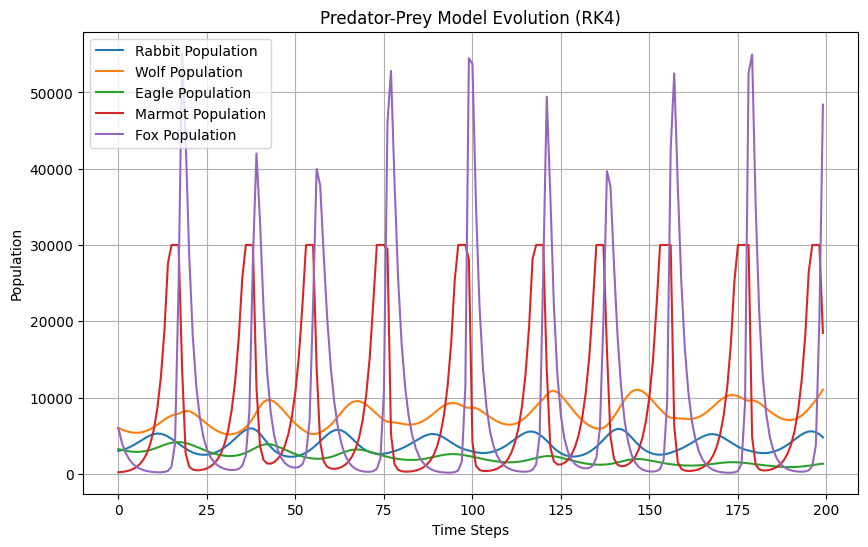

In [81]:
from matplotlib import pyplot as plt

traj = sim.gt_observation.sample(config.n_samples)
populations = traj.dynamics

plt.figure(figsize=(10, 6))
rabbit_idx, wolf_idx, eagle_idx, marmot_idx, fox_idx = 0, 1, 2, 3, 4

# fill population is nan to 30000
populations = np.nan_to_num(populations, nan=30000)
# fill population > 30000 to 30000
populations = np.where(populations > 30000, 30000, populations)
populations = np.where(populations < 0, 0, populations)

plt.plot(populations[: , rabbit_idx][:200], label="Rabbit Population")
plt.plot(50 * populations[: , wolf_idx][:200], label="Wolf Population")
plt.plot(50 * populations[: , eagle_idx][:200], label="Eagle Population")
plt.plot(populations[: , marmot_idx][:200], label="Marmot Population")
plt.plot(50 * populations[: , fox_idx][:200], label="Fox Population")


plt.xlabel("Time Steps")
plt.ylabel("Population")
plt.title("Predator-Prey Model Evolution (RK4)")
plt.legend()    
plt.grid(True)
plt.show()